In [1]:
%run Data_Splitting.ipynb # Splits the dataset into train, test and validation sets

Copying files: 4406 files [00:09, 446.49 files/s]

Help on function ratio in module splitfolders.split:

ratio(input, output='output', seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None)



In [2]:
%%time

from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

Wall time: 4.37 s


In [3]:
%%time
# Height and Width of Input Layer

img_height, img_width = (224, 224)
batch_size = 32

# Train and Test Data

train_data_dir = r"Images\flowers\Flowers_Dataset\Processed\train"
valid_data_dir = r"Images\flowers\Flowers_Dataset\Processed\val"
test_data_dir  = r"Images\flowers\Flowers_Dataset\Processed\test"

Wall time: 0 ns


In [4]:
%%time

train_datagen = ImageDataGenerator (preprocessing_function=preprocess_input, #normalises the image, based on model Arch
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training') # set as training data


valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


test_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation') # set as testing data

Found 1586 images belonging to 5 classes.
Found 348 images belonging to 5 classes.
Found 353 images belonging to 5 classes.
Wall time: 153 ms


In [5]:
%%time

x,y = test_generator.next()
x.shape

Wall time: 29 ms


(1, 224, 224, 3)

In [6]:
%%time

base_model = ResNet50(include_top=False, weights='imagenet') # imagenet = For transferred learned model imagenet datasets

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu') (x)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions) # Transfer learning model

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
              
model.fit(train_generator, epochs = 10)

Epoch 1/10
50/50 [==============================] - 176s 3s/step - loss: 1.2095 - accuracy: 0.6485
Epoch 2/10
50/50 [==============================] - 168s 3s/step - loss: 0.1967 - accuracy: 0.9401
Epoch 3/10
50/50 [==============================] - 157s 3s/step - loss: 0.1584 - accuracy: 0.9438
Epoch 4/10
50/50 [==============================] - 159s 3s/step - loss: 0.1300 - accuracy: 0.9552
Epoch 5/10
50/50 [==============================] - 174s 3s/step - loss: 0.1005 - accuracy: 0.9562
Epoch 6/10
50/50 [==============================] - 155s 3s/step - loss: 0.0924 - accuracy: 0.9702
Epoch 7/10
50/50 [==============================] - 157s 3s/step - loss: 0.0493 - accuracy: 0.9828
Epoch 8/10
50/50 [==============================] - 163s 3s/step - loss: 0.0495 - accuracy: 0.9823
Epoch 9/10
50/50 [==============================] - 167s 3s/step - loss: 0.0546 - accuracy: 0.9819
Epoch 10/10
50/50 [==============================] - 166s 3s/step - loss: 0.0457 - accuracy: 0.9827
Wall time

In [7]:
%%time

# Save the Keras Model

model.save('Resnet50_Flowers.h5')

Wall time: 683 ms


In [8]:
%%time

test_loss, test_acc = model.evaluate(test_generator, verbose = 2)
print ('\nTest Accuracy: ', test_acc*100)

353/353 - 55s - loss: 0.4893 - accuracy: 0.8867

Test Accuracy:  88.66855502128601
Wall time: 55.3 s


In [9]:
%%time

# Summarize the Model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

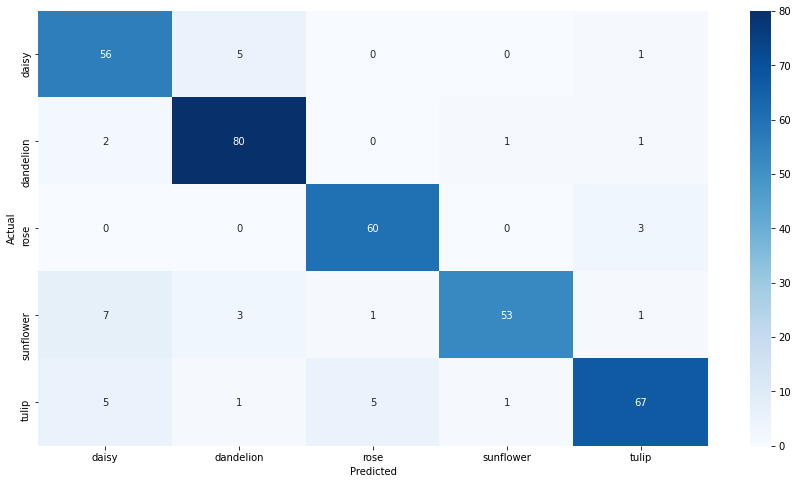

Wall time: 1min 40s


In [10]:
%%time

# Confusion Matrix

model = tf.keras.models.load_model("ResNet50_Flowers.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()

for _ in range(nb_samples):
    X_test,Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd. DataFrame (np.vstack([predicted_class, actual_class]). T, columns=['predicted_class', 'actual_class'])

confusion_matrix = pd.crosstab(out_df['actual_class'],
                               out_df['predicted_class'],
                               rownames=['Actual'], colnames=['Predicted'])

# Plotting the Confusion Matrix
plt.figure(figsize=(15,8))
sns.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()

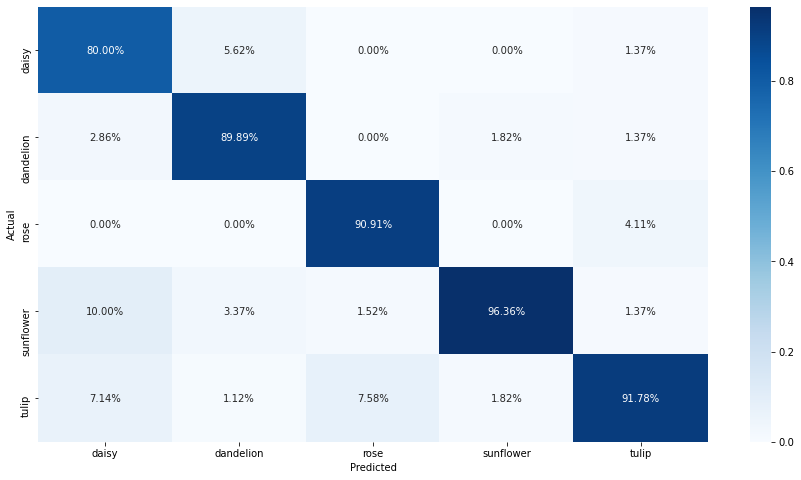

Wall time: 451 ms


In [11]:
%%time

# Plotting the Confusion Matrix with perecentages

plt.figure(figsize=(15,8))
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap = 'Blues')
plt.show()

In [12]:
%%time

print ('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

test accuracy : 89.51841359773371
Wall time: 2 ms


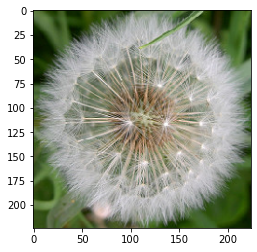

In [13]:
# Loading test images for classification

image_path = r'dandelion.jpg'
img = image.load_img(image_path, target_size=(224,224))
plt.imshow(img)

In [14]:
img_pro = image.load_img(image_path,target_size=(224,224))
img_pro = image.img_to_array(img_pro)
img_pro.shape

img_pro = np.expand_dims(img_pro,axis=0)
img_pro = img_pro/255

In [50]:
model.predict(img_pro)

array([[0.7403273 , 0.20402817, 0.04822515, 0.00411205, 0.00330728]],
      dtype=float32)

In [53]:
preds = model.predict(img_pro)